# Convolutional Neural Network

    - network description

        7 convolution layers with batch normalization
        3 maxpooling layers
        4 affine layers with dropout at the beginning
        Using ReLU for all activation function of hidden layer, and
        log_softmax/CrossEntrophyLoss for the output

---------------------
---------------------
#### 1. Download the CIFAR10 dataset

    first we download the dataset needed, here we use the cifar10 image dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training Data Augmentation :
    # here we apply random changes to our datasets during training
    # we do this so that our network will not overfit
    # this is kinda like adding more images to our dataset but instead of capturing
    # new images and adding it to our dataset, we tweek/augment the current images we
    # have every epoch so that the network will work on slightly different image during training
    # reducing the possibility of overfitting

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

# For the test data set we leave it as it is, no changes are applied
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transform)

print('\ntraining data set number of sample images = ',len(trainset))
print('testing data set number of sample images  = ',len(testset))

Files already downloaded and verified
Files already downloaded and verified

training data set number of sample images =  50000
testing data set number of sample images  =  10000


---------------------
#### 2. Partition the Datset into batches

    here we partition the 50,000 training images into 100, making 500 batches and,
    10,000 sample images of test images into 100, making 100 batches
    
    where each batches contains 100 images

In [ ]:
batch_size = 250

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

---------------------
##### (optionals) check the shape of our datasets

In [ ]:
# here we don't need to flatten every images in our dataset before feeding it to our neural network

for data in trainloader:
    images, labels = data
    print('images dataset shape = ', images.shape)
    print('labels dataset shape = ', labels.shape)
    break

images dataset shape =  torch.Size([250, 3, 32, 32])
labels dataset shape =  torch.Size([250])


---------------------
##### (optionals) Quick peek in the images

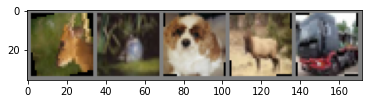

 deer  frog   dog  deer truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[0:5]))

print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

---------------------
#### 3. Build the Convolution Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2, 2, dilation=1)
        self.linDrop = nn.Dropout(p=0.5, inplace=False)
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1))
        self.bn2d1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=(1,1))
        self.bn2d2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=(1,1))
        self.bn2d3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        self.conv4 = nn.Conv2d(32,32, 3, padding=(1,1))
        self.bn2d4 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        
        self.conv5 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.bn2d5 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.bn2d6 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        self.conv7 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.bn2d7 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):

        x = F.relu(self.bn2d1(self.conv1(x)))
        x = F.relu(self.bn2d2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2d3(self.conv3(x)))
        x = F.relu(self.bn2d4(self.conv4(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2d5(self.conv5(x)))
        x = F.relu(self.bn2d6(self.conv6(x)))
        x = F.relu(self.bn2d7(self.conv7(x)))
        x = self.pool(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.linDrop(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
                
        return x

    def shape_progression(self):

        x = torch.ones(size=(1,3,32,32))
        print('single image input shape     = ', x.shape)

        x = F.relu(self.bn2d1(self.conv1(x)))
        print('batch normalized conv1 shape = ', x.shape)
        x = F.relu(self.bn2d2(self.conv2(x)))
        print('batch normalized conv2 shape = ', x.shape)
        x = self.pool(x)
        print('maxpooled conv2 shape        = ', x.shape)
        
        x = F.relu(self.bn2d3(self.conv3(x)))
        print('batch normalized conv3 shape = ', x.shape)
        x = F.relu(self.bn2d4(self.conv4(x)))
        print('batch normalized conv4 shape = ', x.shape)
        x = self.pool(x)
        print('maxpooled conv4 shape        = ', x.shape)
        
        x = F.relu(self.bn2d5(self.conv5(x)))
        print('batch normalized conv5 shape = ', x.shape)
        x = F.relu(self.bn2d6(self.conv6(x)))
        print('batch normalized conv6 shape = ', x.shape)
        x = F.relu(self.bn2d7(self.conv7(x)))
        print('batch normalized conv7 shape = ', x.shape)
        x = self.pool(x)
        print('maxpooled conv7 shape        = ', x.shape)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print('flatten shape shape          = ', x.shape)
        
        x = self.linDrop(x)
        
        x = F.relu(self.fc1(x))
        print('fc1 relued shape shape = ', x.shape)
        x = F.relu(self.fc2(x))
        print('fc2 relued shape shape = ', x.shape)
        x = F.relu(self.fc3(x))
        print('fc3 relued shape shape = ', x.shape)
        x = F.log_softmax(self.fc4(x), dim=1)
        print('fc4 log_softmaxed      = ', x.shape)

net = Net() # CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device) # GPU

print('device in use : ',device)

net

device in use :  cpu


Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linDrop): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2d5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, ke

In [ ]:
net.shape_progression()
# shows the output shapes of each layer

single image input shape     =  torch.Size([1, 3, 32, 32])
batch normalized conv1 shape =  torch.Size([1, 16, 32, 32])
batch normalized conv2 shape =  torch.Size([1, 16, 32, 32])
maxpooled conv2 shape        =  torch.Size([1, 16, 16, 16])
batch normalized conv3 shape =  torch.Size([1, 32, 16, 16])
batch normalized conv4 shape =  torch.Size([1, 32, 16, 16])
maxpooled conv4 shape        =  torch.Size([1, 32, 8, 8])
batch normalized conv5 shape =  torch.Size([1, 64, 8, 8])
batch normalized conv6 shape =  torch.Size([1, 64, 8, 8])
batch normalized conv7 shape =  torch.Size([1, 64, 8, 8])
maxpooled conv7 shape        =  torch.Size([1, 64, 4, 4])
flatten shape shape          =  torch.Size([1, 1024])
fc1 relued shape shape =  torch.Size([1, 64])
fc2 relued shape shape =  torch.Size([1, 64])
fc3 relued shape shape =  torch.Size([1, 64])
fc4 log_softmaxed      =  torch.Size([1, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


---------------------
####  4. Choosing our optimizer
    
    you can use any optimizer you want, either the classic SGD(sochastic gradient descent), 
    or the newer ones like AdaGrad, and etc.
    
    but here we will used the most recent optimizer that is considered
    to be one of the fastest optimizer for updating our neural networks' weight called 'Adam',
    so that we will have a faster convergence and use only a small numbers of epoch(training loop)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

---------------------
#### 5. Train the neural network

In [ ]:
import time

start = time.time()

EPOCH = 10

net.train()

i = 0
for epoch in range(EPOCH):
    i+=1
    print('(',round((i/EPOCH)*100,2),'%) Epoch : ',i,'/',EPOCH, sep='')
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels) # loss function use in tandem with log_softmax
        loss.backward()
        optimizer.step()

end = time.time()
            
dur_sec = end-start
dur_min = dur_sec/60
dur_hr  = dur_min/60

print('Finished Training, \nTraining took',dur_sec,'seconds')
print(dur_min,'min')
print(dur_hr,'hr')

(10.0%) Epoch : 1/10
(20.0%) Epoch : 2/10
(30.0%) Epoch : 3/10
(40.0%) Epoch : 4/10
(50.0%) Epoch : 5/10
(60.0%) Epoch : 6/10
(70.0%) Epoch : 7/10
(80.0%) Epoch : 8/10
(90.0%) Epoch : 9/10
(100.0%) Epoch : 10/10
Finished Training, 
Training took 1483.571438550949 seconds
24.726190642515817 min
0.41210317737526364 hr


In [ ]:
# Access Google Drive Storage
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = 'drive/MyDrive/Colab Notebooks/cnn7L4F_cifar10.pth'
# torch.save(net.state_dict(), PATH)

---------------------
#### (optionals)  Load the model back

In [ ]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

---------------------
#### (optionals)  Try one item in the test dataset using the model

torch.Size([250, 3, 32, 32])


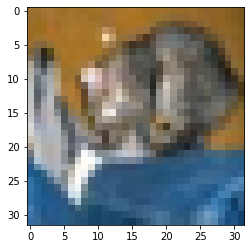

Target label :  cat
Predicted label :  cat


In [ ]:
index = 0

net.eval()

for data in testloader:
    image, label = data[0].to(device), data[1].to(device)
    break

print(images.shape)

selected_image = torch.unsqueeze(image[index],0).to(device)

imshow(image[index].to('cpu'))
print('Target label : ', classes[label[index]])

prediction = net(selected_image)

print('Predicted label : ',classes[prediction.argmax().item()])

---------------------
#### 6. Check the Accuracy of the model from out datasets

In [ ]:
start = time.time()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs, we use with torch.no_grad()
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on training images: %d %%' % (100 * correct / total))
        
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device) # To GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on testing images: %d %%' % (100 * correct / total))

end = time.time()

print('The whole cell took ',(end-start), 'seconds')

Accuracy of the network on training images: 76 %
Accuracy of the network on testing images: 76 %
The whole cell took  66.77710604667664 seconds
